# Captcha Model Predictor
This notebook elaborates on the process of using PyTorch to create a captcha decoder model. 

I also used Abhishek Thakur's video as a base for this, which [you can find here](https://www.youtube.com/watch?v=IcLEJB2pY2Y). However, I implemented some of my own changes such as:

- refactoring the code as a notebook
- using a different dataset
- adding early stopping
- model performance analysis

# Configuration Set-up

We first set up the different variables and load up the necessary libraries that would be needed. 

The libraries loaded here are divided into different parts. First, we have the preprocessing, formatting, and file system libraries. Next, we load the library for the PyTorch model, ImageLoaders, and some sklearn pre-processing and evaluation libraries.

In [1]:
import albumentations
import numpy as np
import pandas as pd
import os
import glob
import random
from pprint import pprint
from tqdm import tqdm

# PyTorch Model
import torch
from torch import nn
from torch.nn import functional as F

# Dataset Loading
from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Model Training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Configurations for the files
DIR = "../input/captcha-images/"
BATCH_SIZE = 16
IMG_HEIGHT = 75
IMG_WIDTH = 300
EPOCHS = 150
NUM_WORKERS = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


# Image Analysis
Before we get started, let's take a look at the different captcha samples that we have. I created a function that gets a random sample from the dataset and shows it to you. To get an idea of what the captcha images look like, let's create subplots of random samples.

In [3]:
paths = []
labels = []
for image in os.listdir(DIR):
    paths.append(os.path.join(DIR, image))
    labels.append(image.split(".")[0])

df = pd.DataFrame({
    "paths": paths,
    "labels": labels
})

df.head()

,paths,labels
0,../input/captcha-images/9PNbWC13Ys.jpg,9PNbWC13Ys
1,../input/captcha-images/8TVve827jK.jpg,8TVve827jK
2,../input/captcha-images/OJ0YWLEie9.jpg,OJ0YWLEie9
3,../input/captcha-images/w3ph8L0ulv.jpg,w3ph8L0ulv
4,../input/captcha-images/9Ia9SnebKw.jpg,9Ia9SnebKw


In [4]:
def show_random_images(df, column_name):
    f = plt.figure(figsize=(10,10))
    i=1
    for i in range(16):
        i += 1
        ax = f.add_subplot(4,4,i)
        sample = random.choice(df[column_name])
        image = mpimg.imread(sample)
        ax.set_title(sample.split("/")[-1])
        plt.imshow(image)


From what we can see, each captcha image contains 10 letters. There isn't much distortion like a usual captcha would have, but the challenge here would be correctly parsing the each character sequentially and dealing with the blurry images.

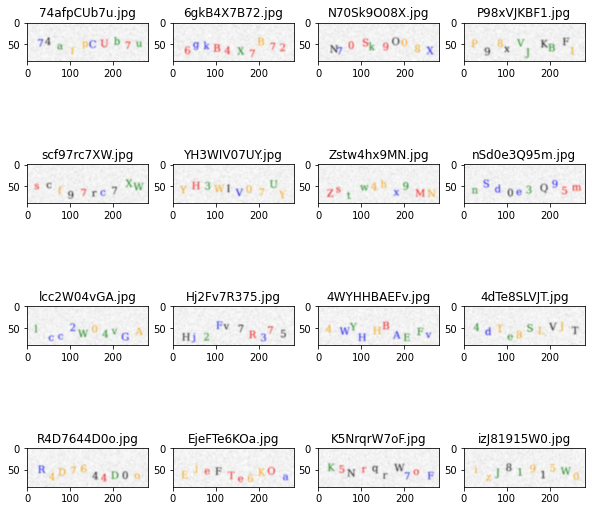

In [5]:
show_random_images(df, "paths")

# Model Definition

We define our model here. The architecture is pretty simple: we use two CNN layers to get information from the images, and then use a GRU to sequentially parse each letter available. 

As for the loss function, we use the CTCLoss to find the error sequentially.

In [6]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [7]:
class MyCaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(MyCaptchaModel, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # RNN Layer Preprocess
        self.linear1 = nn.Linear(1152, 64)
        self.drop1 = nn.Dropout(0.2)
        
        # LSTM GRU
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)
        
        
    def forward(self, images, targets=None):  
        bs, channel, height, width = images.size()
        
        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss
        
        return x, None

Next, we create the train and evaluation functions. These are basically the functions that run for each step, and output the loss of the function. The train function also implements backpropagation and adjusts the weights of the model.

In [8]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)


def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad(): 
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

        return fin_preds, fin_loss / len(data_loader)

# Parse Images & Encode Labels

Now, we get the correct labels for each image. The targets are found in the images' filename, so we parse these and convert them into lists. Once everything is converted into a list, we use sklearn's train_test_split to shuffle and split our train and test sets.

In [9]:
def encode_targets():
  # Load images from files
  image_files = glob.glob(os.path.join(DIR, "*.jpg"))
  image_files_png = glob.glob(os.path.join(DIR, "*.png"))
  image_files.extend(image_files_png)
  targets_orig = [x.split("/")[-1].split(".")[0] for x in image_files]
  targets = [[c for c in x] for x in targets_orig]
  targets_flat = [c for clist in targets for c in clist] # squeeze

  # Encode images
  lbl_enc = LabelEncoder()
  lbl_enc.fit(targets_flat)

  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1 # transform to np and remove 0 index

  return image_files, targets_enc, targets_orig, lbl_enc

In [10]:
# Train-test split
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=0)

## Dataset Classifier Class

To fully utilize PyTorch's features, we create a DatasetClassifier Class, and then use PyTorch's data_loader. This makes the training process smoother and makes it easier to separate the train set by the configured batch size.

In [11]:
ImageFile.LoadTruncatedImages = True

class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        target = self.targets[item]
        
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.BILINEAR)
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [12]:
# Classify images, load using pytorch's DataLoader
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

# Create Model, Optimizers, Callbacks

We now load the model class we developed earlier. We use the Adam Optimizer with a learning rate of 3e-4. We also add callback functions that would adjust the learning rate when it plateaus, and implement early stopping whenever the loss doesn't decrease anymore. These callback functions prevent overfitting of the model.

In [13]:
# Load the models
model = MyCaptchaModel(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

# Create optimizer and callbacks
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

In [14]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop" 
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False

## Decoding the Predictions
Next, we create a function to interpret the predictions. As the predictions are still using the label encoder from earlier, we use the inverse transform for these. If the prediction is not found in the encoder's classes, we assign it as a "filler" and will clean it later on.

In [15]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds

## Running the training model
This process loads in everything we developed earlier. We load the data into the data_loader, and then create predictions based on the CRNN model. The CTCLoss gives out the loss, and then we adjust the weights to create better predictions in the following epoch. Once the loss plateaus, we save the model and use this for predictions.

In [16]:
patience = 6
count = 0
prev_train_loss = 0
threshold = 0.05
loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)
        
    pprint(list(zip(test_orig_targets, valid_cap_preds))[15:20])
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    
    res = early_stopping(patience, count, prev_train_loss, train_loss, threshold)
    
    loss.append(train_loss)
    
    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        prev_train_loss = train_loss

  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 0, train_loss: 5.002602748294918, valid_loss: 4.247873556046259


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 1, train_loss: 4.238760103764373, valid_loss: 4.247573375701904


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 2, train_loss: 4.238816102910423, valid_loss: 4.248346207633851


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 3, train_loss: 4.238645430780007, valid_loss: 4.2471550305684405


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 4, train_loss: 4.2209184157064925, valid_loss: 4.187663585420639


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '-----------------------------------------4---------------------------------'),
 ('Vc0XVdk8Rl',
  '-----------------------------4-----------------4---------------------------'),
 ('Il40rp4HT2',
  '----------------------4-------------------------4--------------------------')]
Epoch: 5, train_loss: 4.039246809419053, valid_loss: 3.905919707010663


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------6-----8-------1------2-----1-------6-----R----8-------3-------'),
 ('y6V9drq2FD',
  '------e------6--------------9----8-------3------------------6------1-------'),
 ('VIQpVKs9cA',
  '--------V---1--------1-----6-------A-----K-------------9-----5-----A-------'),
 ('Vc0XVdk8Rl',
  '-------------2------8--------X-----------------4------8----R-------1-------'),
 ('Il40rp4HT2',
  '-------1------3-------4----8------3------6------4-----H------1-------3-----')]
Epoch: 6, train_loss: 3.402797250087054, valid_loss: 2.571714514777774


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------6-----8-------H-----2------1-------6-----B----8-------3-------'),
 ('y6V9drq2FD',
  '------y------6--------------9----g-------3-----------22-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---1--------Q-----p--------V----K---s---------9-----7-----A-------'),
 ('Vc0XVdk8Rl',
  '-------------c------0--------X---V-------------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------1------3-------4----0------3------p------4-----H------1-------2-----')]
Epoch: 7, train_loss: 2.0598783607381277, valid_loss: 1.4087820866751293


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------H-----3------1-------P-----R----8-------3-------'),
 ('y6V9drq2FD',
  '------y------6-------V------9----q-------3----g------22-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---1--------Q-----p-------V-----K---s---------9-----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------X----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------1------l-------4----0------r------p------4-----H------1------2------')]
Epoch: 8, train_loss: 1.279200418592558, valid_loss: 0.8620128905962384


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----R----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V------9----d-------r---d-------22-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---s---------9-----c----Z--------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------M----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------1------l-------4----0------r------p------4-----H------1------2------')]
Epoch: 9, train_loss: 0.8309743163005496, valid_loss: 0.5483388683152577


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V------9----d-------r---d-------22-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---l--------Q-----p-------V-----K---s---------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------X----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------1------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 10, train_loss: 0.5833181870661239, valid_loss: 0.3743873158144572


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V------9----d-------r----q-------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---s---------9-----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------M----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------1------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 11, train_loss: 0.42722820780417, valid_loss: 0.2494298978930428


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------VV----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---s---------9-----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------A----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 12, train_loss: 0.32878527865740165, valid_loss: 0.193594363118921


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------VV----K---s---------99----c----A--------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------X----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 13, train_loss: 0.2539873402135622, valid_loss: 0.14567278077205023


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---s---------9-----c----A--------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------X---VV------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 14, train_loss: 0.206278897001413, valid_loss: 0.11390929539052266


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------VV----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---s---------99----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0--------X---V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 15, train_loss: 0.16492759057884743, valid_loss: 0.10648363893703809
Patience at 5


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----99----d-------r---q-------22-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---l--------Q-----p-------VV----K---s---------9-----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------X----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 16, train_loss: 0.13975063847050362, valid_loss: 0.07550313764266552


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----33-----1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------VV----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------VV----K---s---------99----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------X----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 17, train_loss: 0.11814324912444736, valid_loss: 0.06310062485909651
Patience at 4


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----33-----1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------VV----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---s---------99----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------X----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 18, train_loss: 0.10122799645070496, valid_loss: 0.054349012805947235
Patience at 3


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----33-----1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------VV----99----d-------r---q-------22-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---s---------99----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------XX---V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 19, train_loss: 0.09044663564402934, valid_loss: 0.050258595082494945
Patience at 2


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----33-----1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------VV----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------VV----K---s---------99----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------X----V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 20, train_loss: 0.07562913481298285, valid_loss: 0.0548586460746943


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------VV----K---s---------99----c----A--------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------X---VV------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 21, train_loss: 0.06933388346888879, valid_loss: 0.039148952220640486
Patience at 1


  0%|          | 0/563 [00:00<?, ?it/s]

[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------VV----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------VV----K---s---------99----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------XX---V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 22, train_loss: 0.06278810071796972, valid_loss: 0.03505171199757901
Patience at 0


100%|██████████| 63/63 [00:02<00:00, 25.00it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D-----3------1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------VV----99----d-------r---q--------2-----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------VV----K---s---------99----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------XX---V------d------k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T------2------')]
Epoch: 23, train_loss: 0.05719758483182579, valid_loss: 0.03008900624182489
Early Stopping Implemented.


In [17]:
torch.save(model.state_dict(), "./model.bin")

# Model Performance

We then create a lineplot to see the change of the loss value throughout the training process. As we can see, the loss goes down and then once it flattens we implement early stopping to prevent overfitting.

<AxesSubplot:title={'center':'Loss During Epoch Training'}, xlabel='Epoch No.', ylabel='Loss Value'>

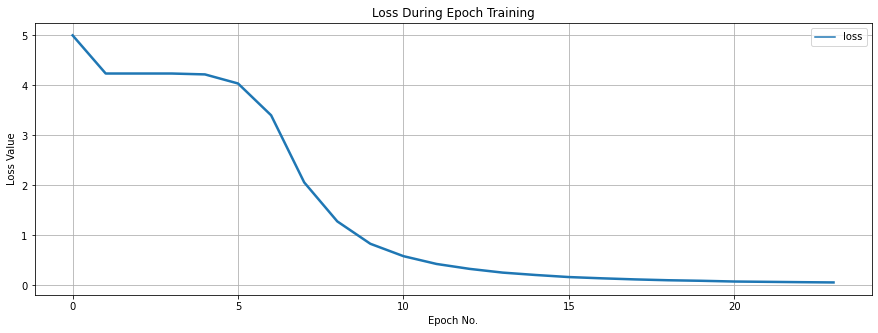

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pytorch = pd.DataFrame({"loss": loss})
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch No.")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
sns.lineplot(data=df_pytorch, palette="tab10", linewidth=2.5)

# Serving Predictions

We then use the trained model weights to create predictions. Similar to the train and evaluation functions earlier, we implement the model. However, we no longer calculate for the loss and adjust the weights. We simply decode the predictions and clean out the results.

In [19]:
def get_image(image_path=None):
    if image_path == None:
        img = random.choice(df["paths"])
        return [img]
    return [image_path]


def get_sample_photo(image_path=None):
    img = get_image(image_path)
    eval_dataset = DatasetClassifier(
        image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
    )

    eval_loader = torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False
    )
    
    return img, eval_loader


def predict_function(model, data_loader):
    model.eval()
    fin_preds = []
    with torch.no_grad(): 
        for data in data_loader:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, _ = model(**data)
            fin_preds.append(batch_preds)

        return fin_preds

In [20]:
image_path, eval_loader = get_sample_photo()
print(image_path)

def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)
            
    cleaned_predictions = "".join(cleaned_predictions)
    
    if len(cleaned_predictions) == 10:
        return cleaned_predictions   
    
    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res
    
def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("/")[-1].split(".")[0]
    plt.title(image_path[0].split("/")[-1])
    plt.imshow(image)
    
    valid_preds = predict_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])
    
    success = True if preds == target else False

    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

['../input/captcha-images/825R19EF3c.jpg']


# Sample Predictions

The function now samples a random image. It also tells us if the prediction is correct by comparing the predictions to the file name.

{'success': True, 'prediction': '825R19EF3c', 'real': '825R19EF3c'}

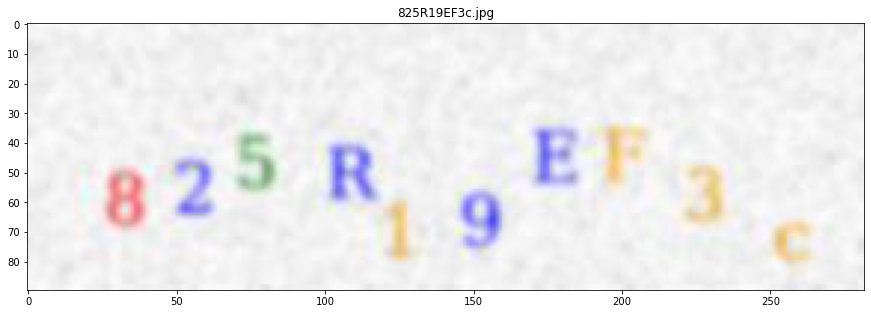

In [21]:
preds = predict_captcha(model, eval_loader, image_path)
preds